# Fit Example Using Method of Moving Asymptotes From `NLopt`

This example shows how to apply [Method of Moving Asymptotes (MMA)](https://nlopt.readthedocs.io/en/latest/NLopt_Algorithms/#mma-method-of-moving-asymptotes-and-ccsa) from `NLopt` to the linear interpolant provided by `nevis`, so as to find a local maximum on the GB height map.

## Optimisation

Install `nlopt` if needed:

In [ ]:
%pip install nlopt

Ensure that you have downloaded the OS Terrain data:

In [2]:
import nevis
nevis.download_os_terrain_50()
nevis.howdy() # Print the current version number

Downloaded, unpacked, and processed file already found: Skipping.

                |>          
 Starting Ben   |   Nevis   
               / \    version
            /\/---\     0.1.0
           /---    \/\      
        /\/   /\   /  \     
     /\/  \  /  \_/    \    
    /      \/           \   


First, we load the linear interpolant on the GB height data from `nevis`. MMA is a gradient-based algorithm, so we use `grad=True` to get both the function value and the gradient at each point. We then get the dimensions of the data, later used as bounds for optimisation.

In [3]:
f_grad = nevis.linear_interpolant(grad=True)
x_max, y_max = nevis.dimensions()

Let's focus on a neighborhood of the hill of [Schiehallion](https://en.wikipedia.org/wiki/Schiehallion) (in Scotland) and plot this region:

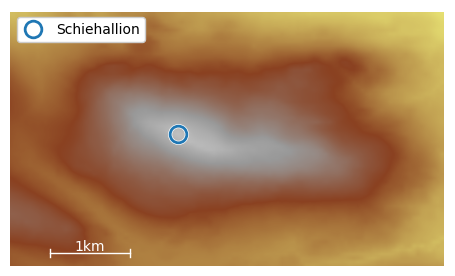

In [4]:
import matplotlib.pyplot as plt
hill, boundaries = nevis.schiehallion()
nevis.plot(
    boundaries=boundaries,
    labels={
        hill.name: hill.coords
    },
    zoom=4,
)
plt.show()

We define a wrapper around `f` to save all visited points to a list.

In [5]:
import nlopt
points = []
def myfunc(u, grad):
    x, y = u
    points.append([x, y])
    z, (gx, gy) = f_grad(x, y)
    if grad.size > 0:
        grad[0] = gx
        grad[1] = gy
    return z

Next, we optimise the interpolant in this region using MMA. We randomly select a point in this region as `x0`. Relative tolerance on function value is set to `1e-9` and maximum optimization time `3` seconds.

In [6]:
import numpy as np

x1, x2, y1, y2 = boundaries
a = np.random.rand() * (x2 - x1) + x1
b = np.random.rand() * (y2 - y1) + y1

opt = nlopt.opt(nlopt.LD_MMA, 2)
opt.set_lower_bounds([x1, y1])
opt.set_upper_bounds([x2, y2])
opt.set_max_objective(myfunc)
opt.set_xtol_rel(1e-9)
opt.set_maxtime(3)

x, y = opt.optimize([a, b])
z = opt.last_optimum_value()

We then obtain the solution point and its corresponding function value. To find out where the optimiser has taken us to, we print the formatted result:

In [7]:
nevis.print_result(x, y, z)

Congratulations!
You landed at an altitude of 1071m.
  https://opentopomap.org/#marker=15/56.666872/-4.099676
You are 35m from the nearest named hill top, "Schiehallion",
  ranked the 115th highest in GB.
  http://hillsummits.org.uk/htm_summit/103.htm


We also print the total number of function evaluations for benchmarking:

In [8]:
print(f'Number of function evaluations: {len(points)}.')

Number of function evaluations: 49.


## Plot

Some preparations for plotting the optimisation results:

In [9]:
points = np.array(points)
c = nevis.Coords(gridx=x, gridy=y)

Figure 1: A zoomed map with your location and visted points:

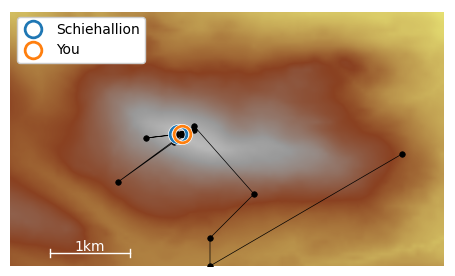

In [10]:
labels = {
    hill.name: hill.coords,
    'You': c,
}
nevis.plot(
    boundaries=boundaries,
    labels=labels,
    trajectory=points,
    zoom=4,
)
plt.show()

Figure 2: Height along the line from Schiehallion to our location (note that there might be some discrepancies between a local maximum point of the interpolant from the 50m x 50m data grid and the corresponding hill location in the database):

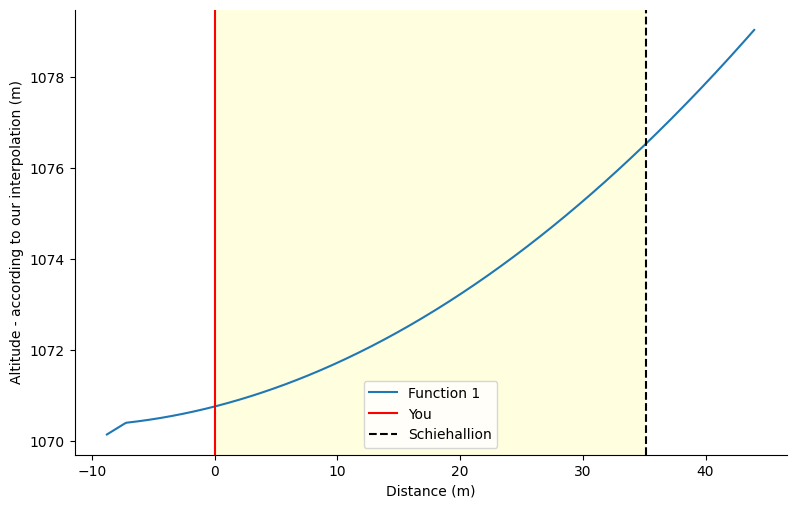

In [11]:
f = nevis.linear_interpolant()
nevis.plot_line(f, c, hill.coords, 'You', hill.name)
plt.show()